# EDA

In [1]:
#--------------------------Basic imports-------------------------------------
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import iqr, probplot, normaltest
from matplotlib.ticker import StrMethodFormatter
from itertools import compress
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

#--------------------------Sklearn imports-------------------------------------
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

def read_data(path, print_summary=True, **kwargs):
    '''
    Function reads in csv from path, prints info about the table and first 5 rows.
    
    Inputs:
    path - string path of csv file
    
    Returns:
    pandas DF
    '''
    data = pd.read_csv(path, **kwargs)
    if print_summary:
        print(data.info())
        display(data.head())
    return data

def check_duplicates(df, drop=False, **kwargs):
    '''
    Prints number of duplicates in df
    
    Inputs:
    df - pandas data frame
    drop - False/True drops duplicates
    kwargs - arguements for pandas.DataFrame.drop_duplicates
    Returns:
    copy of df
    '''
    dups = df.duplicated().sum()
    print(f'{dups} duplicates present')
    if drop:
        df = df.drop_duplicates(**kwargs)
    return df

def drop_change_cols(df, drop_cols, change_col_type=None):
    '''
    Function drops columns in drop cols and changes col types inplace
    
    Inputs:
    df - pandas dataframe
    drop_cols - list of col names to drop inplace
    change_col_type - dictionary with {type: [col_names]}
    
    Returns:
    None, makes changes inplace
    '''
    df.drop(columns=drop_cols, inplace=True)
    if change_col_type:
        for dtype, cols in change_col_type.items():
            df[cols] = df[cols].astype(dtype)
    return 

def extract_columns_by_type(df):
    '''
    Accepts df and extracts lists of columns by type
    
    Inputs:
    df - pandas data frame
    
    Returns:
    tuple with lists of columns ([cat_cols], [cont_cols])
    '''
    cat_cols = df.select_dtypes(exclude=np.number).columns.to_list()
    cont_cols = df.select_dtypes(include=np.number).columns.to_list()
    return cat_cols, cont_cols

#______________________________________Numerical Columns______________________________________
def filter_outliers(df, column):
    '''
    Functions filters out outliers by Q1 - 1.5 IQR and Q3 + 1.5 * IQR
    
    Inputs:
    df - pandas df
    column - string column name
    
    Returns:
    df - filtered data frame, copy of original
    '''
    IQR = iqr(df[column])
    Q1 = np.quantile(df[column], 0.25)
    Q3 = np.quantile(df[column], 0.75)
    filter_outliers = (df[column].between(Q1 - 1.5*IQR, Q3 + 1.5*IQR))
    return df[filter_outliers]

def univariate_plots(df, col, target, qq_axis=None, box_axis=None, hist_axis=None, **hist_kwargs):
    '''
    Function plots Q-Q plot, box plot and histogram
    
    df - pandas df with data
    col - column name to plot
    qq_axis, box_axis - only plots axis that aren't None will get plotted
    box_kwargs - additional arguements for sns.boxplot
    
    Returns:
    QQ plot - ax2
    Box Plot - ax1
    Adds D'Agostino and Pearson's P-value to titles
    '''
    data = df[col]
    stat, p = normaltest(data.dropna())
    if box_axis:
        sns.boxplot(data=df, y=target, x=col, ax=box_axis)
        box_axis.set_title(f'{col.capitalize()} Box Plot')
    if qq_axis:
        probplot(data.dropna(), plot=qq_axis)
        qq_axis.set_title(f'{col.capitalize()} Q-Q plot (P value {p:.2})')
    if hist_axis:
        sns.histplot(data=df[[col, target]], x=col, hue=target, 
                     multiple='stack', ax=hist_axis, **hist_kwargs)
        hist_axis.set_title(f'{col.capitalize()} Histogram')
    return
    
def corr_plot(df, ax):
    '''
    Function plots pearson correlation matrix between all columns
    
    Inputs:
    df - pandas df
    ax - plotting axis
    
    Returns:
    Plots on ax, returns None
    '''
    corr = df.corr()
    ordered = corr.sum().sort_values().index.to_list()
    sns.heatmap(corr.loc[ordered, ordered], annot=True, ax=ax, cmap=plt.cm.Reds)
    return

def inspect_cont_cols(df, target='target', hue_order=None):
    '''
    Function plots QQ and box plot for each column in df, excluding target column
    
    Inputs:
    df - pandas df with all continuous columns and target
    target - target column name for box plots and histogram
    
    Returns:
    None - plots the output
    '''
    cols = len(df.columns) - 1
    fig, axs = plt.subplots(cols, 3, figsize=(15, cols*3))
    for ax, col in zip(axs, df):
        univariate_plots(df, col, target, *ax, hue_order=hue_order)
    fig.tight_layout()
    return

#__________________________________Categorical Columns_________________________________
def convert_X_for_cat_correlation(df, n_cols, c_cols):    
    '''
    Function takes in df and numertical and categorical cols lists and scales numerical
    Encodes categorical with OrdinalEncoder
    
    Inputs:
    df - pandas dataframe with all columns
    n_cols - list of numerical columns
    c_cols - list of cat columns
    
    Returns:
    converted converted/scaled X
    '''
    X_cont = StandardScaler().fit_transform(df[n_cols])
    X_cat = OrdinalEncoder().fit_transform(df[c_cols].fillna('NA'))
    X_transformed = pd.DataFrame(X_cont, columns=n_cols).join(pd.DataFrame(X_cat, columns=c_cols))
    return X_transformed

def compute_cat_corrs(x, y):
    '''
    Function to compute correlation for categorical columns, sumplemental to cat_corr_plot
    '''
    return mutual_info_classif(np.expand_dims(x, 1), y, discrete_features=True)[0]

def cat_corr_plot(df, n_cols, c_cols, ax, sort=False):
    '''
    Plots correlation heatmap for categorical columns
    Inputs:
    df - pandas dataframe with all columns
    n_cols - list of numerical columns
    c_cols - list of cat columns
    
    Returns:
    None
    '''
    X_transformed = convert_X_for_cat_correlation(df, n_cols, c_cols)
    cat_corr = X_transformed[c_cols].corr(method=compute_cat_corrs)
    if sort:
        ordered = cat_corr.sum().sort_values().index.to_list()
        cat_corr = cat_corr.loc[ordered, ordered]
    sns.heatmap(cat_corr, ax=ax, cmap=plt.cm.Reds)
    return

def inspect_cat_cols(df, target, max_unique_vals = 10, hue_order=None):
    '''
    Function plots histogram with counts
    
    Inputs:
    df - pandas df, includes all categorical columns and target col
    target - column name with target variable
    max_unique_values - cols with above this threshold won't get plotted
    hue_order - how to color categories
    
    Returns:
    None - plots required plots
    '''
    #filtering out columns with nunique above threshold
    cols = df.columns[df.nunique() < max_unique_vals].to_list()
    cols.remove(target)
    #setting up plotting area
    plot_cols = 2
    plot_rows = math.ceil(len(cols)/plot_cols)
    fig, axs = plt.subplots(math.ceil(plot_rows), plot_cols, figsize=(15, plot_rows * 3.5))
    
    for ax, col in zip(axs.ravel(), cols):
        t = data[[col, 'target']].value_counts().unstack()
        t['c'] = t['- 50000.'].add(t['50000+.'], fill_value=0)
        t.sort_values('c', inplace=True)
        t[hue_order].plot(kind='barh', stacked=True, ax=ax)
        ax.set_ylabel('')
        ax.set_xlabel(None)
        ax.set_title(f'{col}')
    fig.tight_layout()
    return

def read_excel_codes(sheet_name):
    '''
    Function accepts sheet name and reads from Column Names spreadsheet 
    to extract id's and descriptions for that sheet.
    
    Returns table with ids and descriptions
    '''
    table = pd.read_excel(r'Column Names.xlsx', sheet_name=sheet_name, header=None)
    table.dropna(inplace=True)
    table = table.iloc[:,0].str.split(n=1, expand=True)
    table.rename(columns={0:'id', 1:'description'}, inplace=True)
    table.reset_index(inplace=True, drop=True)
    return table


def map_categorical_columns(df, cols):
    '''
    Function takes in dataframe with all columns and a list of tuples (cols).  
    Maps ids to descriptions from excel sheet.
    
    Inputs:
    df - dataframe with all columns
    cols - list of column names to map, sheet names are identical to col name in table
    
    Returns none mapping is done inplace
    '''
    for col in cols:
        codes = read_excel_codes(col)
        df[col] = df[col].map(codes.description.to_dict(), na_action='ignore')
    return 

in_col_names = [
    'age',
    'class_of_worker',
    'industry_code',
    'occupation_code',
    'education',
    'wage_per_hour',
    'enrolled_in_edu_inst_last_wk',
    'marital_status',
    'major_industry_code',
    'major_occupation_code',
    'race',
    'hispanic_Origin',
    'sex',
    'member_of_a_labor_union',
    'reason_for_unemployment',
    'employment_stat',
    'capital_gains',
    'capital_losses',
    'dividends_from_stocks',
    'tax_filer_status',
    'region_of_previous_residence',
    'state_of_previous_residence',
    'detailed_household_and_family_stat',
    'detailed_household_summary_in_household',
    'instance_weight',
    'migration_code-change_in_msa',
    'migration_code-change_in_reg',
    'migration_code-move_within_reg',
    'live_in_this_house_1_year_ago',
    'migration_prev_res_in_sunbelt',
    'num_persons_worked_for_employer',
    'family_members_under_18',
    'country_of_birth_father',
    'country_of_birth_mother',
    'country_of_birth_self',
    'citizenship',
    'own_business_or_self_employed',
    'fill_inc_questionnaire_for_veterans_admin',
    'veterans_benefits',
    'weeks_worked_in_year',
    'year',
    'target'
]
data = read_data('census_income_learn.csv', sep=', ', names=in_col_names, na_values='?')
print(f'{data.duplicated().sum()} duplicates')
data[data.duplicated(keep=False)].sort_values(['age', 'year']).head(2)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 42 columns):
 #   Column                                     Non-Null Count   Dtype  
---  ------                                     --------------   -----  
 0   age                                        199523 non-null  int64  
 1   class_of_worker                            199523 non-null  object 
 2   industry_code                              199523 non-null  int64  
 3   occupation_code                            199523 non-null  int64  
 4   education                                  199523 non-null  object 
 5   wage_per_hour                              199523 non-null  int64  
 6   enrolled_in_edu_inst_last_wk               199523 non-null  object 
 7   marital_status                             199523 non-null  object 
 8   major_industry_code                        199523 non-null  object 
 9   major_occupation_code                      199523 non-null  object 
 10  race    

,age,class_of_worker,industry_code,occupation_code,education,wage_per_hour,enrolled_in_edu_inst_last_wk,marital_status,major_industry_code,major_occupation_code,...,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,fill_inc_questionnaire_for_veterans_admin,veterans_benefits,weeks_worked_in_year,year,target
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


3229 duplicates


,age,class_of_worker,industry_code,occupation_code,education,wage_per_hour,enrolled_in_edu_inst_last_wk,marital_status,major_industry_code,major_occupation_code,...,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,fill_inc_questionnaire_for_veterans_admin,veterans_benefits,weeks_worked_in_year,year,target
422,0,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
708,0,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


<b>Can't drop duplicates because they might represent a different person.  Since there is no unique identifier per person dropping duplicates might drop records corresponding to different people.</b>

## Continuous Variables

In [2]:
#metadata states not to use instance_weight for classifier, therefore dropping the column
#migration code columns are missing over 50% of the data, will drop those features since majority is missing
#also need to change some columns to str type to convert to categorical features

col_names = ['migration_code-change_in_msa',
            'migration_code-change_in_reg',
            'migration_code-move_within_reg',
            'migration_prev_res_in_sunbelt',
            'instance_weight']

#dropping col_names and changing year and occupation code to str for categorical variables
drop_change_cols(data, col_names, change_col_type={str:['year', 'occupation_code']})

#mapping codes to descriptions
map_categorical_columns(data, ['industry_code', 
                               'own_business_or_self_employed', 
                               'veterans_benefits'])

data.describe()

,age,wage_per_hour,capital_gains,capital_losses,dividends_from_stocks,num_persons_worked_for_employer,weeks_worked_in_year
count,199523.000000,199523.000000,199523.00000,199523.000000,199523.000000,199523.000000,199523.000000
mean,34.494199,55.426908,434.71899,37.313788,197.529533,1.956180,23.174897
std,22.310895,274.896454,4697.53128,271.896428,1984.163658,2.365126,24.411488
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,15.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,33.000000,0.000000,0.00000,0.000000,0.000000,1.000000,8.000000
75%,50.000000,0.000000,0.00000,0.000000,0.000000,4.000000,52.000000
max,90.000000,9999.000000,99999.00000,4608.000000,99999.000000,6.000000,52.000000


In [3]:
cat_cols, cont_cols = extract_columns_by_type(data)
nas = data[cont_cols].isna().sum()
zeros = (data[cont_cols]==0).sum()
pd.DataFrame(nas.rename('NA')).join(zeros.rename('Zeros'))

,NA,Zeros
age,0,2839
wage_per_hour,0,188219
capital_gains,0,192144
capital_losses,0,195617
dividends_from_stocks,0,178382
num_persons_worked_for_employer,0,95983
weeks_worked_in_year,0,95983


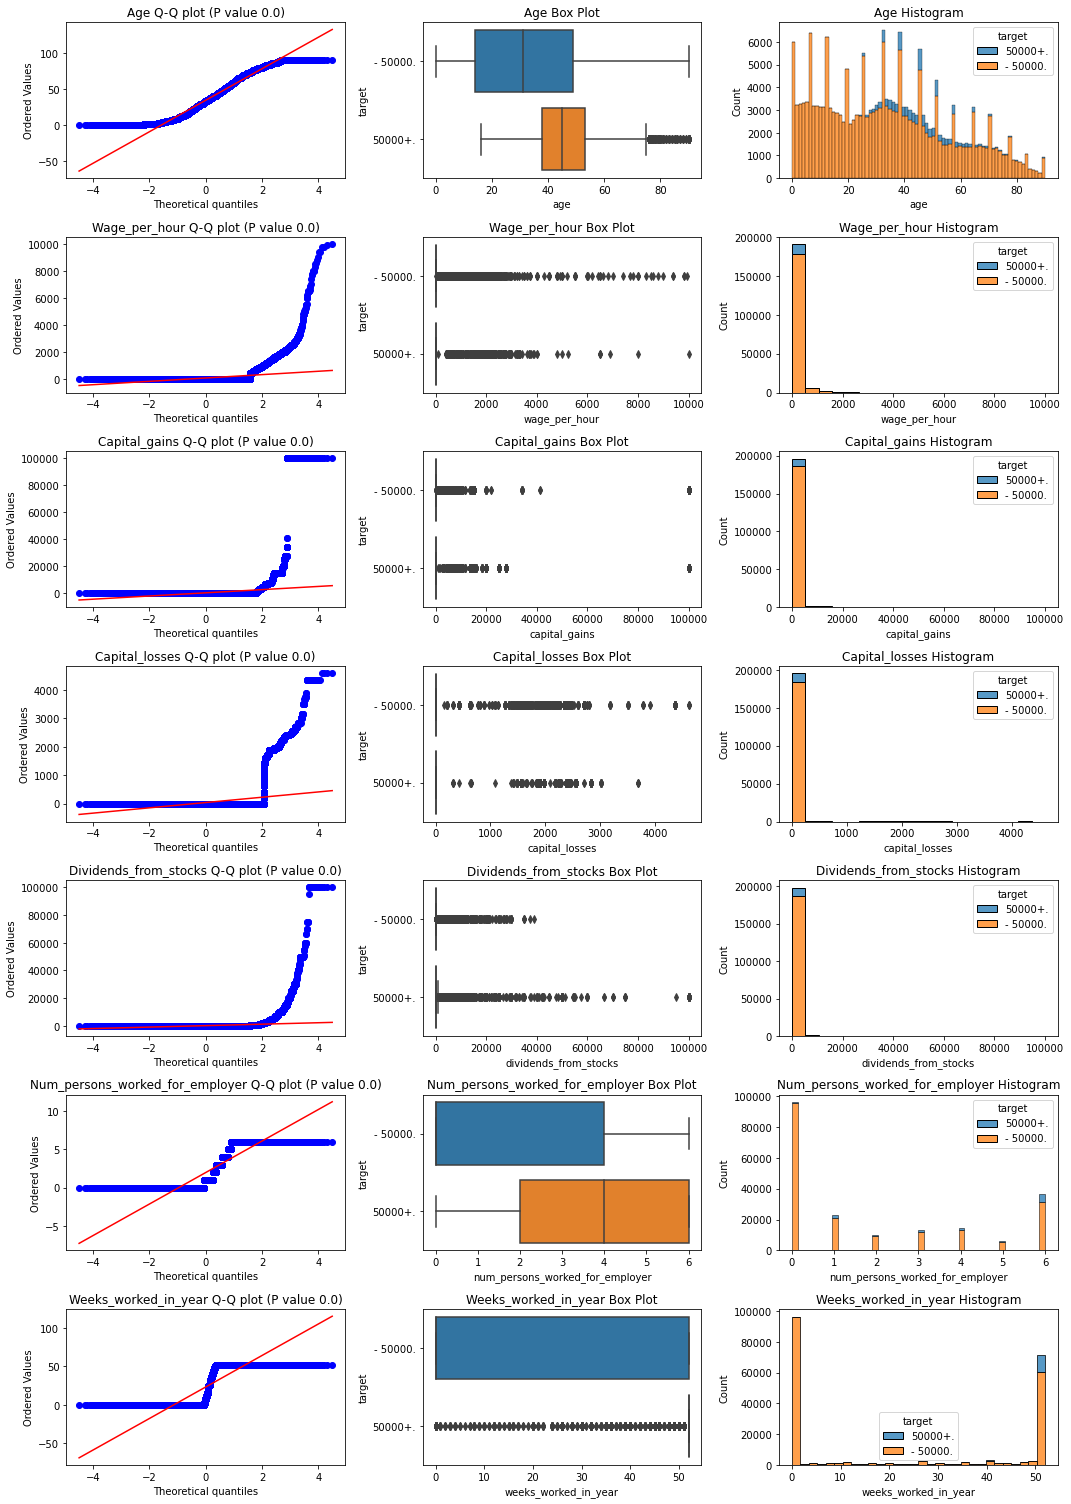

In [4]:
hue_order=['50000+.', '- 50000.']
inspect_cont_cols(data[cont_cols+['target']], hue_order=hue_order)

<b>Take-Aways:</b>  
1. P-values are 0 for all distributions --> none are normal distributions.  
2. Age feature distribution shows that people over 30 are more likely to make 50k / year.  
3. Age also indicates different stages of professional career.  Teenagers work more during school, then drop off due most likely to college attendance and another increase in counts occur after students graduate and enter work force.  
4. Wage/hr, Capital Gains / Losses and Dividends have some extreme outliers, scaling should resolve the issue.  
5. Num persons worked for employer is far from normal.  Majority have values are 0 (no employees), suggests that employers with over 1000 employees are much more likely to make over 50k a year.  
6. Weeks worked in Year displays a good separation between classes, people that work 52 weeks in a year are mainly the population making over 50k.  

Features that indicate good separation between classes (Weeks worked in year, age, number of employees) would have high importance on random forest due to if - else filtering on thresholds.

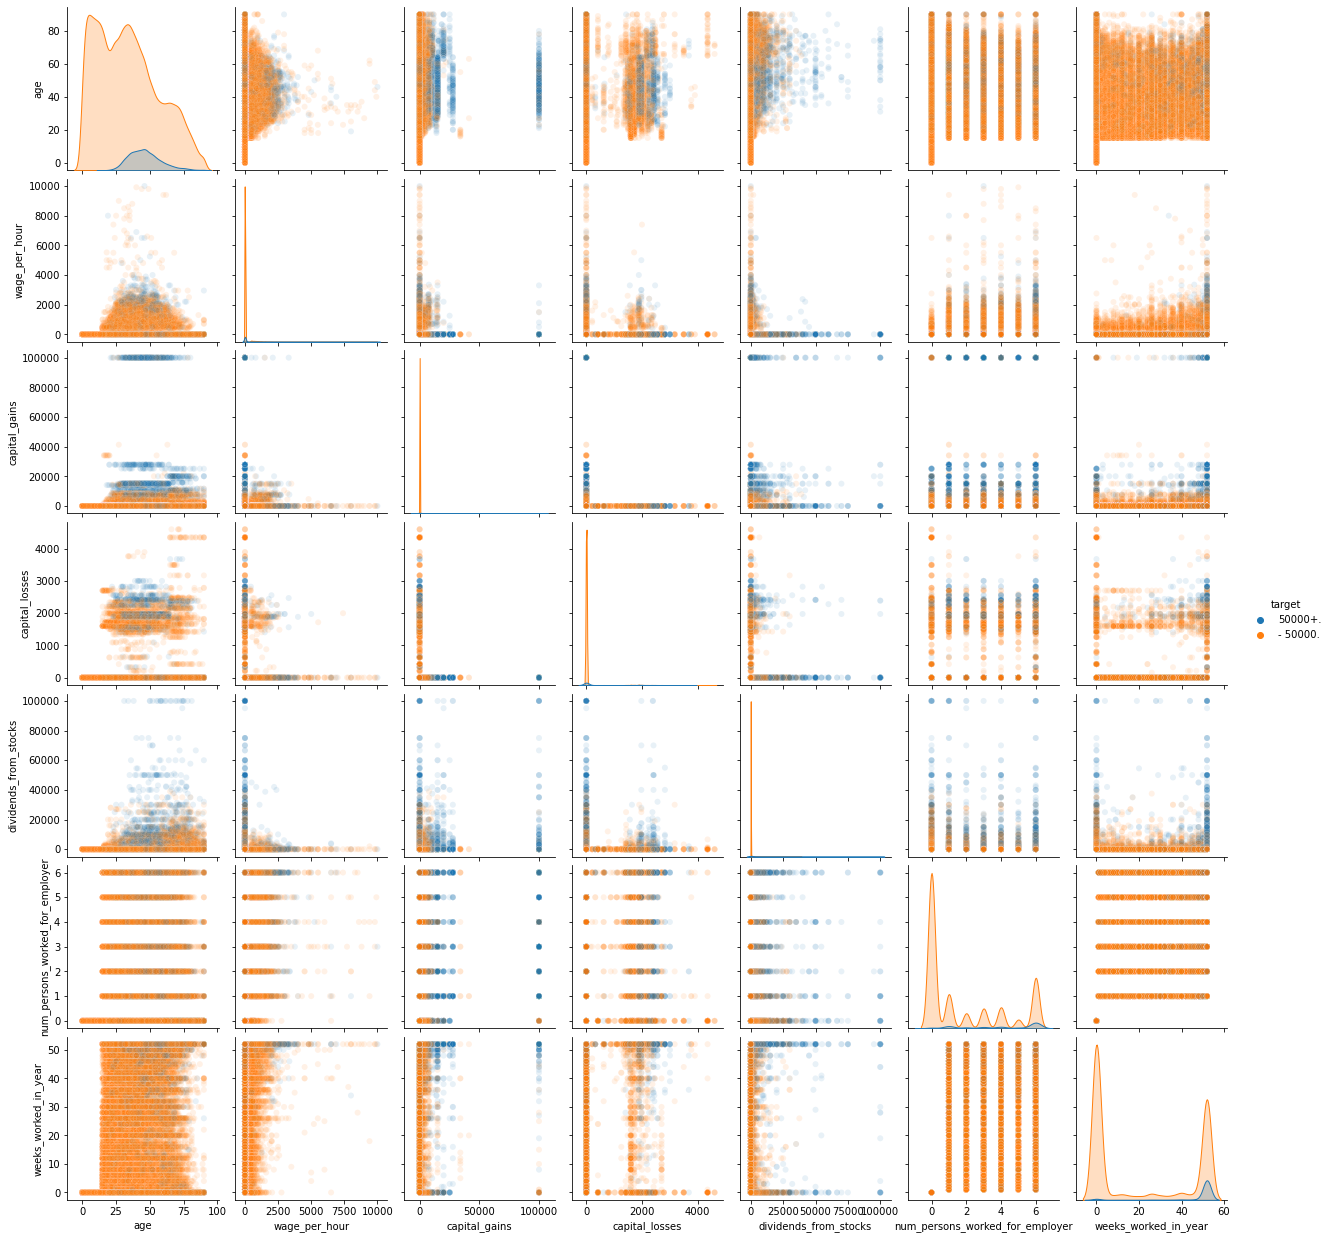

In [5]:
sns.pairplot(data=data[cont_cols + ['target']], 
             plot_kws={'alpha': 0.1}, 
             hue='target', hue_order=hue_order)

<b>Take-Aways:</b>  
1. Age and Capital gains plot show a pretty clear separation between classes.  
2. Capital gains and num persons cross plot shows a good separation between classes.  
3. Wage per Hour and Age seem to separate the classes.  
4. Combination of some features can separate the classes with quadratic equation and not a straight line, so will try polynomial expansion on Logistic Regression (weeks_worked_in_year, dividends_from_stocks).

Since logistic regression attempts to draw a hyperplane that separates the classes, features stated above would have high importance for Logistic Regression and should have decent results.

## Categorical Variables

In [6]:
#removing target from categorical columns
cat_cols.remove('target')

def count_nas_uniques(df):
    '''
    Function counts NAs and unique values for each column
    '''
    nas = pd.DataFrame(df.isna().sum().rename("NA's"))
    unique = df.nunique().rename('Unique Counts')
    return nas.join(unique)

count_nas_uniques(data)

,NA's,Unique Counts
age,0,91
class_of_worker,0,9
industry_code,0,52
occupation_code,0,47
education,0,17
wage_per_hour,0,1240
enrolled_in_edu_inst_last_wk,0,3
marital_status,0,7
major_industry_code,0,24
major_occupation_code,0,15


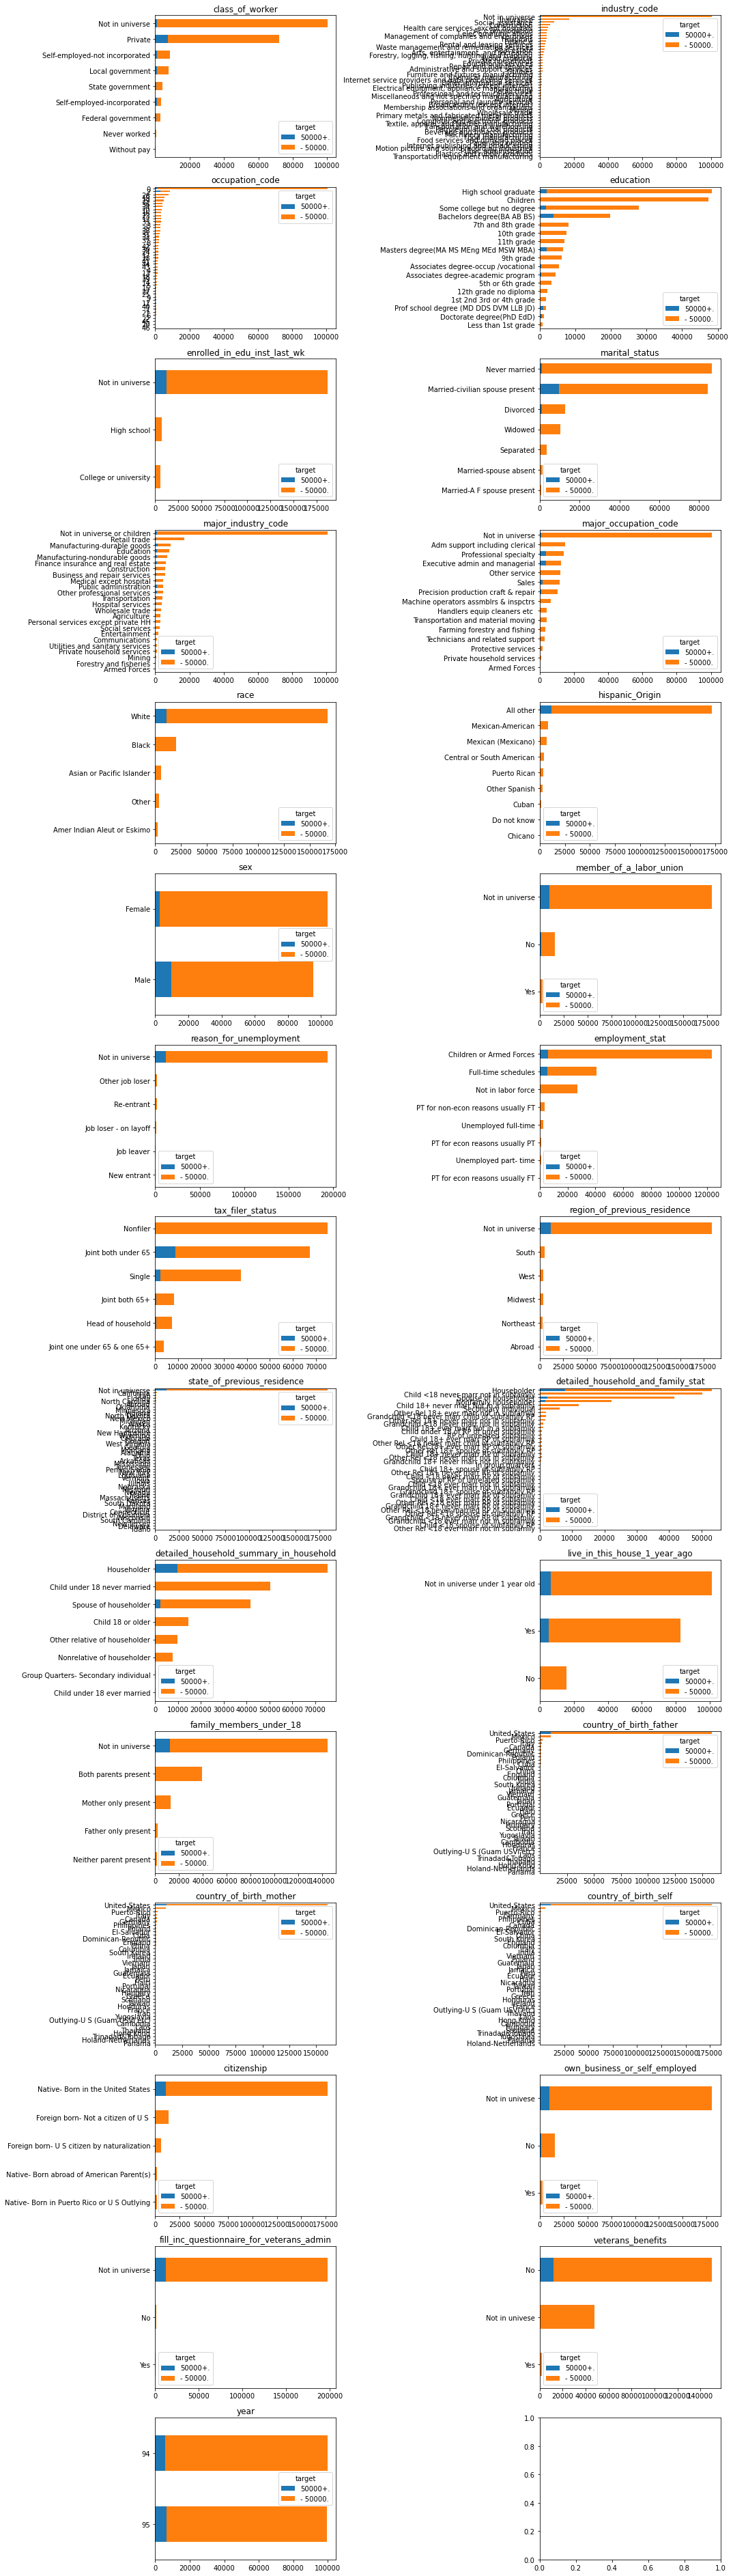

In [7]:
inspect_cat_cols(data[cat_cols+['target']], 'target', max_unique_vals=55, hue_order=hue_order)

<b>Take-Aways:</b>  
1. Features that have primarily the same value won't contribute much to the model because all the data is classified as one type.  Example reason for unemployment, mainly all the data is not in universe category, therefore the model won't have any luch determining which class the input is, since both classes mainly have not in universe for unemployment reason.

## Similar Features

### Education - Enrollment

With all Categories


target,- 50000.,50000+.
education,,
Prof school degree (MD DDS DVM LLB JD),0.459565,0.540435
Doctorate degree(PhD EdD),0.479810,0.520190
Masters degree(MA MS MEng MEd MSW MBA),0.688427,0.311573
Bachelors degree(BA AB BS),0.802920,0.197080
Associates degree-academic program,0.905570,0.094430
Associates degree-occup /vocational,0.922919,0.077081
Some college but no degree,0.935766,0.064234
High school graduate,0.961183,0.038817
12th grade no diploma,0.984008,0.015992


Crosstab for Education and Enrollement


enrolled_in_edu_inst_last_wk,College or university,High school,Not in universe
education,,,
10th grade,24,2356,5177
11th grade,46,2218,4612
12th grade no diploma,55,466,1605
1st 2nd 3rd or 4th grade,0,7,1792
5th or 6th grade,2,19,3256
7th and 8th grade,3,258,7746
9th grade,12,1364,4854
Associates degree-academic program,178,1,4184
Associates degree-occup /vocational,103,1,5254


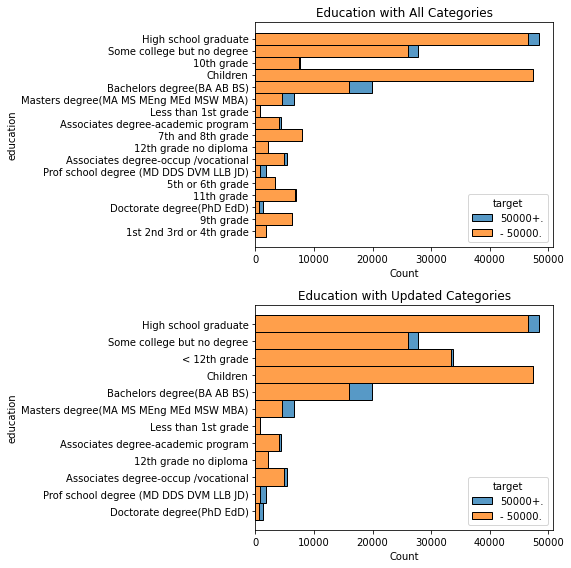

In [8]:
def plot_hist(df, col_name, ax, title, hue_order, orient='h'):
    '''
    Function plots a histogram from df.  DF is expected to be a 2 column table. 
    col_name will be used for count and second column is used to color
    '''
    second_col = list(set(df.columns) - {col_name})[0]
    if orient=='h':
        direction = dict(y=col_name)
    else:
        direction = dict(x=col_name)
    
    sns.histplot(data=df,
                 hue=second_col, multiple='stack',
                 hue_order=hue_order, ax=ax, **direction)
    ax.set_title(title)
    return


fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8, 8))
#first histogram with original education values
plot_hist(data[['target', 'education']], 'education', ax1, 'Education with All Categories', hue_order)

#mapping new values
combined_values = ['10th grade', '7th and 8th grade', '5th or 6th grade',
       '11th grade', '9th grade', '1st 2nd 3rd or 4th grade']
mapped_education = data[['education']].mask(data.education.isin(combined_values), '< 12th grade')
mapped_education = mapped_education.join(data.target)

#plotting new histogram
plot_hist(mapped_education, 'education', ax2, 'Education with Updated Categories', hue_order)

fig.tight_layout()

print('With all Categories')
display(pd.crosstab(index=data.education, columns=data.target, normalize='index').sort_values(hue_order[1]))

print('Crosstab for Education and Enrollement')
display(pd.crosstab(data.education, data.enrolled_in_edu_inst_last_wk))
#setting a new column and will select one vs the other for the model
data['remapped_education'] = mapped_education.education
cat_cols.append('remapped_education')

<b>Take-Aways:</b>  

Education feature has some values that could be combined into 1 to reduce computation time.  Since the ordinality of the variable > 10 target encoding will have to be utilized.  Target encoding replaces a categorical variable with a blend of posterior probability of the target given particular categorical value and the prior probability of the target over all the training data, as long as categories have similar frequencies of target variable they can be combined.
    
Lastly, enrolled_in and education are closesly related (from table above).  Additionally, enrollement column is missing majority of records (Not in Universe), therefore education is most likely a better predictor and enrollement won't be utilized by the model.

### Employment - Reason for Unemployment

employment_stat,Children or Armed Forces,Full-time schedules,Not in labor force,PT for econ reasons usually FT,PT for econ reasons usually PT,PT for non-econ reasons usually FT,Unemployed full-time,Unemployed part- time
reason_for_unemployment,,,,,,,,
Job leaver,301,0,0,0,0,0,257,40
Job loser - on layoff,501,0,0,0,0,0,382,93
New entrant,224,0,0,0,0,0,89,126
Not in universe,120504,40736,26808,525,1209,3322,91,258
Other job loser,1148,0,0,0,0,0,855,35
Re-entrant,1091,0,0,0,0,0,637,291


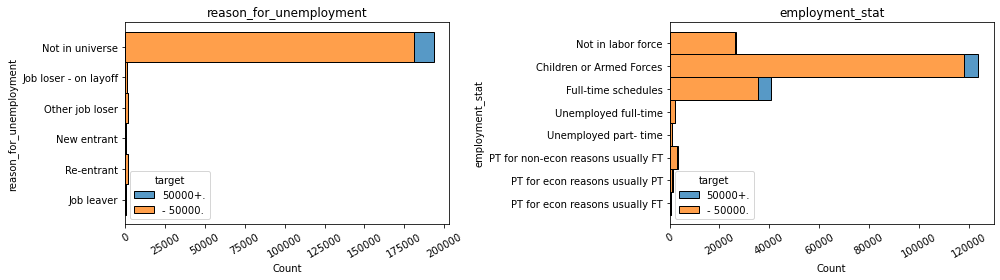

In [9]:
display(pd.crosstab(data.reason_for_unemployment, data.employment_stat))

fig, axs = plt.subplots(1,2, figsize=(14, 4))

for ax, col in zip(axs.ravel(), ['reason_for_unemployment', 'employment_stat']):
    plot_hist(data[[col, 'target']], col, ax, col, hue_order)
    ax.tick_params(axis='x', rotation=30)
fig.tight_layout()

<b>Take-Aways:</b>  
1. Reason for unemployment doesn't really suplement employment_stat, mainly because majority of the data is not in Universe.  
2. Reason for unemployment won't be selected by the model, most likely.


## Not informative columns

,NA's,Unique Counts
state_of_previous_residence,708,50
region_of_previous_residence,0,6
country_of_birth_father,6713,42
country_of_birth_mother,6119,42
country_of_birth_self,3393,42
fill_inc_questionnaire_for_veterans_admin,0,3
year,0,2


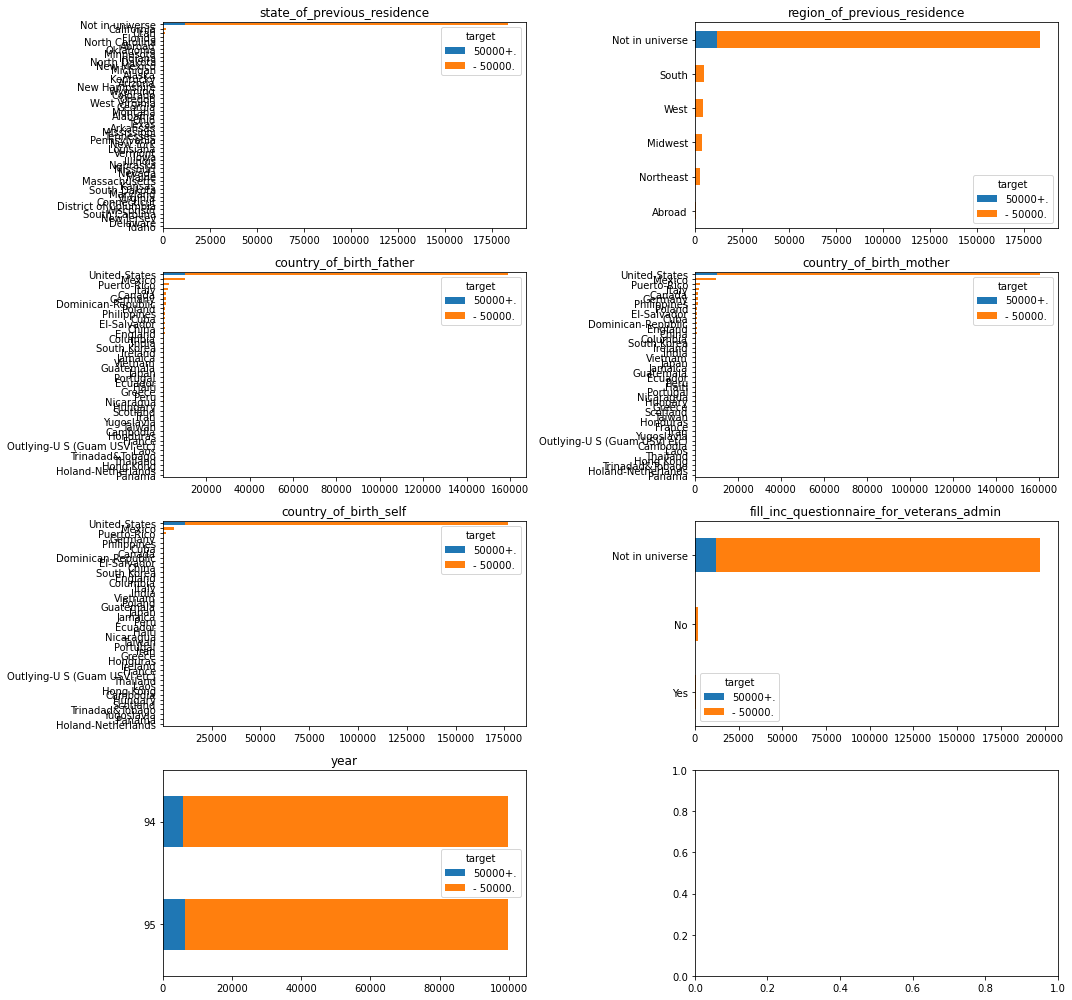

In [10]:
#will inspect country of birth and previous state of residence
col_names = ['state_of_previous_residence', 'region_of_previous_residence',
             'country_of_birth_father',
             'country_of_birth_mother', 'country_of_birth_self', 
             'fill_inc_questionnaire_for_veterans_admin', 'year']

inspect_cat_cols(data[col_names + ['target']], 'target', 60, hue_order)
count_nas_uniques(data[col_names])

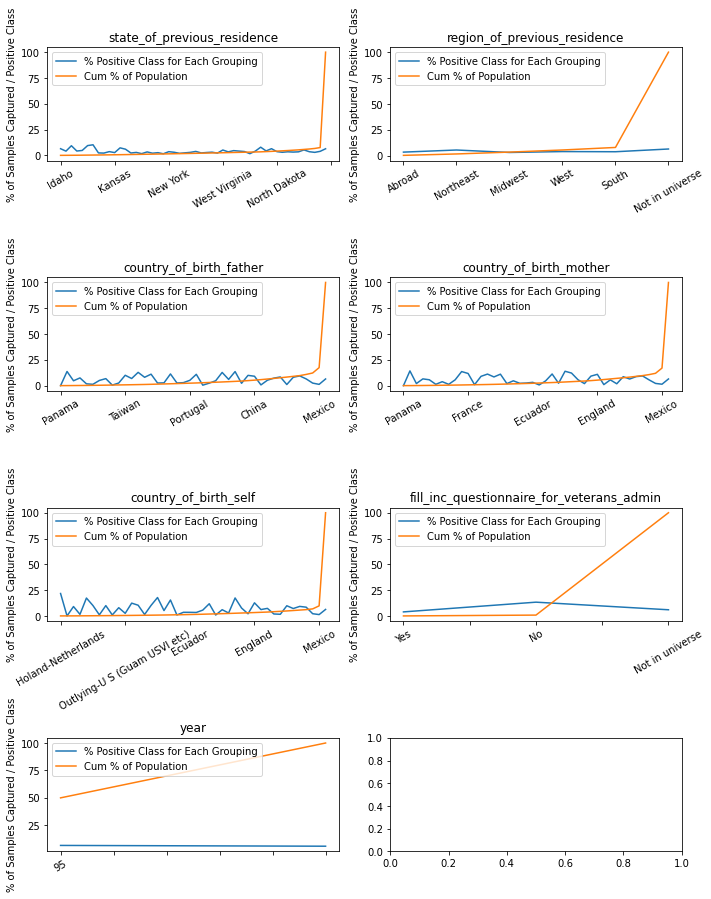

In [11]:
fig, axs = plt.subplots(math.ceil(len(col_names)/2), 2, figsize=(10, 12))
for col, ax in zip(col_names, axs.ravel()):
    #computing fraction of total samples captured
    ct = pd.crosstab(index=data[col], margins=True, margins_name='Cum % of Population',
                     columns=data.target, normalize='columns').sort_values('Cum % of Population')
    
    #computing % of posisitive labels per country
    ct2 = pd.crosstab(index=data[col], columns=data.target, normalize='index')
    ct2 = ct2.join(ct['Cum % of Population'])
    ct2.sort_values('Cum % of Population', inplace=True)
    ct2['Cum % of Population'] = ct2['Cum % of Population'].cumsum()
    ct2.rename(columns={'50000+.': '% Positive Class for Each Grouping'}, inplace=True)
    (ct2.iloc[:,1:] * 100).plot(ax=ax)
    ax.set_title(col)
    ax.set_xlabel('')
    ax.set_ylabel('% of Samples Captured / Positive Class')
    ax.tick_params(axis='x', labelrotation = 30)

fig.tight_layout()

<b>Take-Aways:</b>  
1. Overwhelming majority of samples for these feature are within the same category, therefore low chance a model will utilize these column as important features.  
2. Frequencies of positive class for all features (especially previous state) are also similar so it won't be informative for models as well. 

## Target Variable

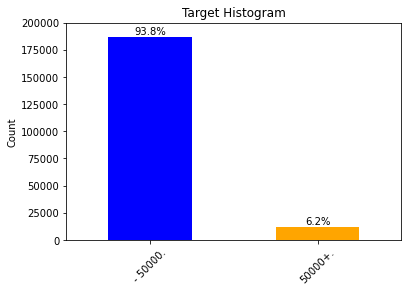

In [12]:
def inspect_target():
    '''
    Function plots a histogram of target by class.  
    Created function mainly to keep workspace variables clean
    '''
    ax = data.target.value_counts().plot(kind='bar', color=['blue', 'orange'])
    labels = (data.target.value_counts() / data.shape[0]) * 100
    labels = labels.round(1).astype(str).apply(lambda x: x+'%')
    ax.bar_label(ax.containers[0], labels=labels, fmt='%.1f%%')
    ax.set_ylim(top=200000)
    ax.set_title('Target Histogram')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', labelrotation = 45)
    return

inspect_target()

<b>If model overall accuracy is above 93.8% then model has learned something, otherwise picking majority class should result in a minimum of majority class frequency.</b>

# Data Preparation

## Feature Selection

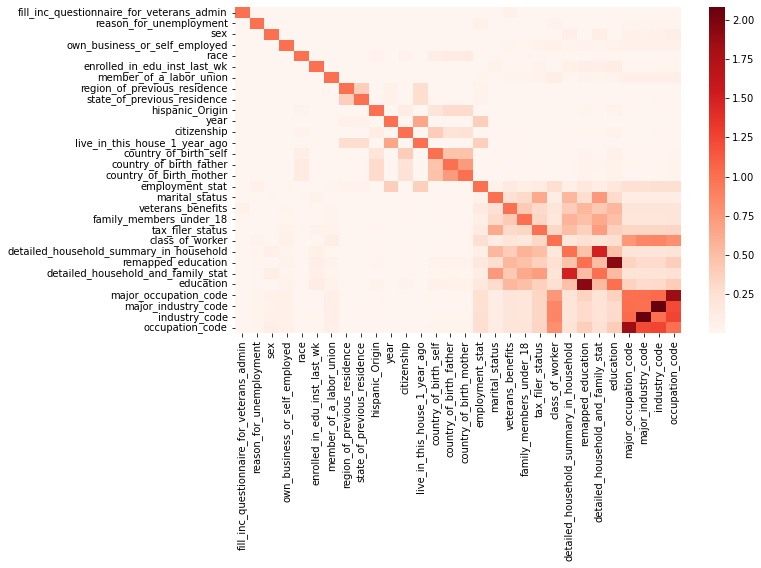

In [13]:
fig, ax = plt.subplots(figsize=(10,6))
cat_corr_plot(data, cont_cols, cat_cols, ax, sort=True)

<b>Take-Aways:</b>  
1. Strong correlation between Occupation Codes and Major occupation code, same with Industry codes. 
2. Detailed household stats and family stats are correlated as well.  
3. Similar with country of birth fields.

Text(0.5, 1.0, 'Correlation')

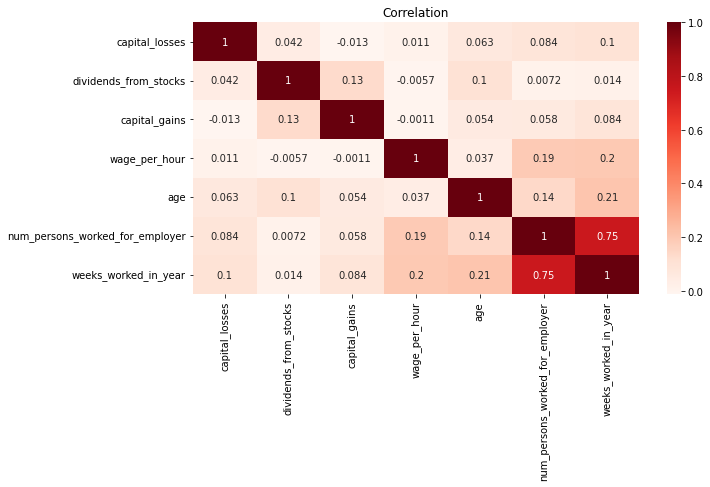

In [14]:
fig, ax = plt.subplots(figsize=(10,5))

corr_plot(data[cont_cols], ax)
ax.set_title('Correlation')

<b>Take-Aways:</b>  
1. Num Persons worked for employer and weeks worked in year have high positive correlation, should only pick one of the two if using Logistic Regression, for Random Forest won't have an impact, but it will provide instability during random splits.  
2. Will run corelation test to target during feature selection and drop the least informative of the 2 features.

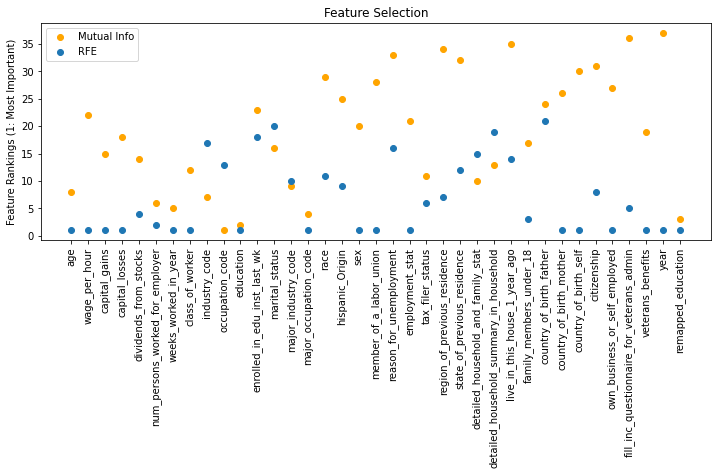

In [15]:
#--------------------------Sklearn imports-------------------------------------
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif, RFECV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import classification_report
from skopt import BayesSearchCV

def compose_CT(df, n_cols, c_cols, model='logistic', OHE_max_ord=10):
    '''
    Function builds a column transformer for logistic regression and rf models.  No imputation is performed.
    
    Inputs:
    df - data
    n_col ,c_col - lists
    model - [logistic ], anything else will return ct with categorical variables encoded with Target
    
    Returns ct
    '''
    if model=='logistic':
        #setting up column lists
        ohe_cols = (df[c_cols].nunique() < OHE_max_ord).to_list()
        ohe_cols = list(compress(c_cols, ohe_cols))
        c_cols = list(set(c_cols) - set(ohe_cols))
        
        ct = ColumnTransformer([('cont_cols', StandardScaler(), n_cols),
                                ('OHE_cols', OneHotEncoder(handle_unknown='ignore'), ohe_cols),
                                ('target_cols', TargetEncoder(), c_cols)])
    else:
        ct = ColumnTransformer([('target_cols', TargetEncoder(), c_cols)], 
                                 remainder='passthrough')
    return ct

def get_RFE_coeffs(rfe_subsample):
    X_subsample, _, y_subsample, _ = train_test_split(data[cont_cols+cat_cols],
                                                  data.target, stratify=data.target, train_size=rfe_subsample)
    X_subsample.fillna('NA', inplace=True)
    y_subsample = y_subsample.map({'- 50000.':0, '50000+.':1})
    ct = compose_CT(data, cont_cols, cat_cols, model='rf')
    X_subsample_transf = ct.fit_transform(X_subsample, y_subsample)

    rfe = RFECV(RandomForestClassifier(class_weight='balanced', n_estimators=200, max_depth=3, n_jobs=-1)
                ,cv=StratifiedKFold(n_splits=5, shuffle=True))
    rfe.fit(X_subsample_transf, y_subsample)
    return rfe.ranking_

def plot_feature_selection(rfe_subsample=0.1):
    X_transformed = convert_X_for_cat_correlation(data, cont_cols, cat_cols)
    p = mutual_info_classif(X_transformed, data.target, 
                            discrete_features=X_transformed.columns.isin(cat_cols))
    #ordering values, high MI score should be ranked lowest
    p = pd.Series(p).rank(ascending=False).values
    rfe = get_RFE_coeffs(rfe_subsample)

    x_labels = cont_cols + cat_cols

    fig, ax = plt.subplots(figsize=(12, 4))
    ax.scatter(x_labels, p,  label='Mutual Info', color='orange')
    ax.scatter(x_labels, rfe,  label='RFE')
    ax.set_title('Feature Selection')
    ax.set_ylabel('Feature Rankings (1: Most Important)')
    ax.tick_params(axis='x', rotation=90)
    ax.legend()
    return

plot_feature_selection(0.3)

In [16]:
#dropping correlated features and re-running features selection
#major occupation code has more importance for MI and RFE and higher variance, will keep and drop occupation code
#similar with industry code, keeping major industry code
#remapped education has less categories and importance is similar, can drop
dropped_cat = ['major_industry_code', 'major_occupation_code', 'remapped_education', 'reason_for_unemployment', 
               'enrolled_in_edu_inst_last_wk']
dropped_cont = ['num_persons_worked_for_employer']
cont_cols_FS = list(set(cont_cols) - set(dropped_cont))
cat_cols_FS = list(set(cat_cols) - set(dropped_cat))

# Data Modeling

Now will obtain base scores for Logistic Regression, RF and Gradient Boosting

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

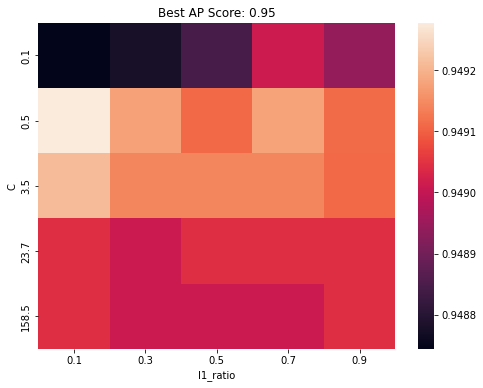

In [17]:
def build_model_pipeline(X, n_cols, c_cols, model, OHE_max_ord=10):
    '''
    Model inputs: logistic, rf, gb (sklearn objects)
    
    Return pipeline
    '''
    model_name = 'logistic' if model.__class__.__name__ == 'LogisticRegression' else 'other'
    ct = compose_CT(X, n_cols, c_cols, model_name, OHE_max_ord)
    
    pipe = Pipeline([('ct', ct),
                     ('model', model)])
    return pipe   

def prep_X_y(X_raw, y_raw, print_nas=False):
    '''
    Fills in NAs in X with 'NA'
    maps y positive and negative classes
    '''
    nas = count_nas_uniques(X_raw)["NA's"]
    if print_nas:
        print(nas[nas>0])
    X_raw = X_raw.fillna('NA')
    #minority class is positive
    y_raw = y_raw.map({'50000+.':1, '- 50000.':0})
    return X_raw, y_raw
         
#Need to split train data to have a validation set for feature importances and probability calibrations
FS_cols = cont_cols_FS + cat_cols_FS
X, y = prep_X_y(data[FS_cols], data.target)
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y)

def multifidel_and_bayes_search(model, X, y, param_grid, param_grid_bayes,
                                subsample=0.1, bayes_subsample=0.7, 
                                bayes_iter=5, scoring='accuracy', plot=True, ax=None):
    
    X_bayes, _, y_bayes, _ = train_test_split(X, y, stratify=y, train_size=bayes_subsample)
    X_mf, _, y_mf, _ = train_test_split(X, y, stratify=y, train_size=subsample)
    
    grid_bayes = BayesSearchCV(model, param_grid_bayes, 
                               n_iter=bayes_iter, scoring=scoring,
                               cv=StratifiedKFold(), n_jobs=-1)
    grid_bayes.fit(X_bayes, y_bayes)

    grid = GridSearchCV(model, param_grid=param_grid, scoring=scoring,
                        cv=StratifiedKFold(), n_jobs=-1)
    grid.fit(X_mf, y_mf)
    
    best_params_ = grid.best_params_ if grid.best_score_ > grid_bayes.best_score_ else grid_bayes.best_params_
    
    #plotting
    if plot:
        best_score = max(grid.best_score_, grid_bayes.best_score_)
        params = list(param_grid.keys())
        first = param_grid[params[0]]
        second = param_grid[params[1]]
        results = grid.cv_results_['mean_test_score'].reshape(len(first), -1)
        sns.heatmap(results, xticklabels=second.round(1), 
                    yticklabels=first.round(1), ax=ax)
        ax.set_xlabel(params[1].replace('model__',''))
        ax.set_ylabel(params[0].replace('model__',''))
        ax.set_title(f'Best AP Score: {best_score:.2f}')
    return best_params_

#prepping Logreg for multifidel search

log_reg = build_model_pipeline(X_train, cont_cols_FS, cat_cols_FS, 
                               LogisticRegression(n_jobs=-1, warm_start=True,
                                                  penalty='elasticnet', solver='saga'))

param_grid = {'model__C': np.logspace(-1.1, 2.2, num=5), 
              'model__l1_ratio': np.linspace(0.1, 0.9, num=5)}

param_grid_bayes = {'model__C': (1e-1, 1e+3, 'log-uniform'), 
                    'model__l1_ratio': (0.01, 0.99),
                    'model__class_weight': ['balanced', None]}

fig, ax = plt.subplots(figsize=(8,6))
log_reg_best_params = multifidel_and_bayes_search(log_reg, X_train, y_train, 
                                                  param_grid, param_grid_bayes, subsample=0.2,
                                                  bayes_subsample=0.6, bayes_iter=10, ax=ax)

(0.9556344098955514, 50)

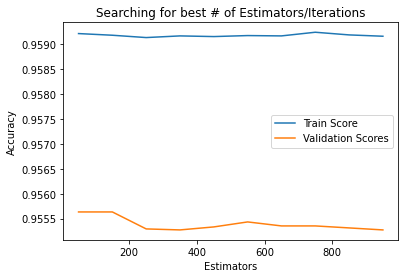

In [18]:
rf = build_model_pipeline(X_train, cont_cols_FS, cat_cols_FS, 
                          RandomForestClassifier(n_jobs=-1, max_depth=10, 
                                                 max_features=13, warm_start=True))

def tune_estimators(model, X, y, X_v, y_v, trees=[50, 1000], gb=False):
    trees = np.arange(trees[0], trees[1]+1, 100)
    train_scores = []
    val_scores = []
    for estimators in trees:
        if gb:
            model.set_params(model__max_iter = estimators)
        else:
            model.set_params(model__n_estimators = estimators)
        model.fit(X, y)
        train_scores.append(model.score(X, y))
        val_scores.append(model.score(X_v, y_v))

    fig, ax = plt.subplots()
    ax.plot(trees, train_scores, label='Train Score')
    ax.plot(trees, val_scores, label='Validation Scores')
    ax.set_xlabel('Estimators')
    ax.set_ylabel('Accuracy')
    ax.set_title('Searching for best # of Estimators/Iterations')
    ax.legend()
    best_trees = trees[np.argmax(val_scores)]
    return (max(val_scores), best_trees)

tune_estimators(rf, X_train, y_train, X_val, y_val)

Best # of Features: 29


([0.9510635312042661,
  0.9542511176600309,
  0.9550931216294781,
  0.9551733124837112,
  0.9554740281870853,
  0.9555742667548766,
  0.9556544576091097,
  0.9557747438904592,
  0.9556945530362262,
  0.9556945530362262,
  0.9559150778853672,
  0.9559351255989255,
  0.9558749824582506,
  0.9559551733124837],
 array([ 3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]))

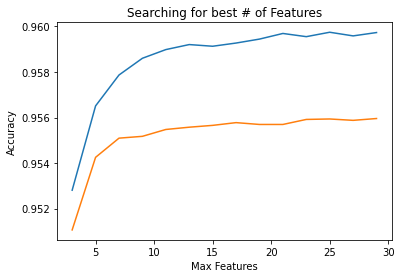

In [19]:
rf.set_params(model__n_estimators=300)
rf.set_params(model__warm_start=False)

def tune_max_features(model, X, y, X_v, y_v):
    max_features = np.arange(3, X.shape[1], 2)
    val_scores = []
    train_scores = []
    for feat in max_features:
        model.set_params(model__max_features = feat)
        model.fit(X ,y)
        train_scores.append(model.score(X, y))
        val_scores.append(model.score(X_v, y_v))

    fig, ax = plt.subplots()
    ax.plot(max_features, train_scores, label='Train Score')
    ax.plot(max_features, val_scores, label='Validation Scores')
    ax.set_xlabel('Max Features')
    ax.set_ylabel('Accuracy')
    ax.set_title('Searching for best # of Features')
    best_feat = max_features[np.argmax(val_scores)]
    model.set_params(model__max_features = best_feat)
    print(f'Best # of Features: {best_feat}')
    return (val_scores, max_features)

tune_max_features(rf, X_train, y_train, X_val, y_val)

(0.9577995629598445, 800)

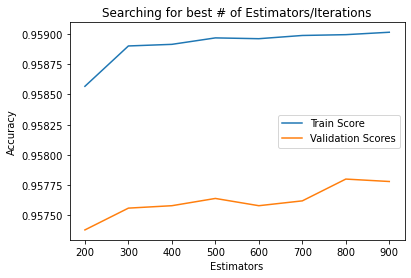

In [20]:
from sklearn.ensemble import HistGradientBoostingClassifier
rf.set_params(model__max_features=25)

gbc = build_model_pipeline(X_train, cont_cols_FS, cat_cols_FS, 
                          HistGradientBoostingClassifier(warm_start=True, max_depth=4,
                                                         n_iter_no_change=5, learning_rate=0.1))

tune_estimators(gbc, X_train, y_train, X_val, y_val, trees=[200, 900], gb=True)

Original Threshold
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     46785
           1       0.75      0.43      0.54      3096

    accuracy                           0.96     49881
   macro avg       0.86      0.71      0.76     49881
weighted avg       0.95      0.96      0.95     49881

Adjusted Threshold
              precision    recall  f1-score   support

           0       0.99      0.87      0.93     46785
           1       0.31      0.87      0.46      3096

    accuracy                           0.87     49881
   macro avg       0.65      0.87      0.70     49881
weighted avg       0.95      0.87      0.90     49881



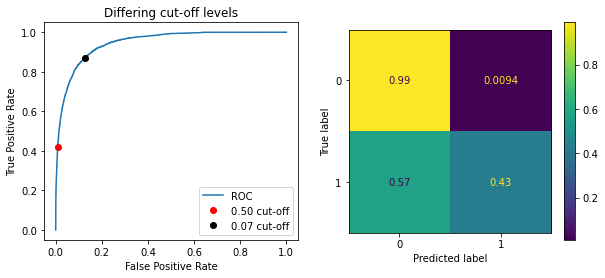

In [21]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, roc_curve, classification_report
from sklearn.inspection import permutation_importance


gbc.set_params(model__max_iter=600, model__warm_start=False)

def score_model(model, X_t, y_t, X, y, best_cut_off=None):
    model.fit(X,y)
    fpr, tpr, thresh = roc_curve(y_t, model.predict_proba(X_t)[:,1])
    #finding 0.5 threshold
    cut_off_poss = np.isclose(thresh, 0.5, rtol=0.01).argmax()
    cut_off = thresh[cut_off_poss]
    if best_cut_off:
        best_cut_off_pos = np.isclose(thresh, best_cut_off, rtol=0.01).argmax()
        cut_off = thresh[cut_off_poss]
    else:
        #finding closest point to top left corner
        best_cut_off_pos = (((1-tpr) ** 2 + (fpr)**2)**0.5).argmin()
        best_cut_off = thresh[best_cut_off_pos]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    ax1.plot(fpr, tpr, label='ROC')
    ax1.plot(fpr[cut_off_poss], tpr[cut_off_poss], 'or', label=f'{cut_off:.2f} cut-off')
    ax1.plot(fpr[best_cut_off_pos], tpr[best_cut_off_pos], 'ok', label=f'{best_cut_off:.2f} cut-off')
    ax1.legend()
    ax1.set_title('Differing cut-off levels')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_xlabel('False Positive Rate')

    #changin positive threshold to best one found
    plot_confusion_matrix(model, X_t, y_t, ax=ax2, normalize='true')
    y_prob = model.predict_proba(X_t)[:,1]
    y_pred_adj = y_prob > best_cut_off
    y_pred = y_prob > 0.5
    print('Original Threshold')
    print(classification_report(y_t, y_pred))
    print('Adjusted Threshold')
    print(classification_report(y_t, y_pred_adj))
    return

score_model(rf, X_val, y_val, X_train, y_train)

Original Threshold
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     46785
           1       0.76      0.45      0.57      3096

    accuracy                           0.96     49881
   macro avg       0.86      0.72      0.77     49881
weighted avg       0.95      0.96      0.95     49881

Adjusted Threshold
              precision    recall  f1-score   support

           0       0.99      0.88      0.93     46785
           1       0.33      0.88      0.48      3096

    accuracy                           0.88     49881
   macro avg       0.66      0.88      0.70     49881
weighted avg       0.95      0.88      0.90     49881



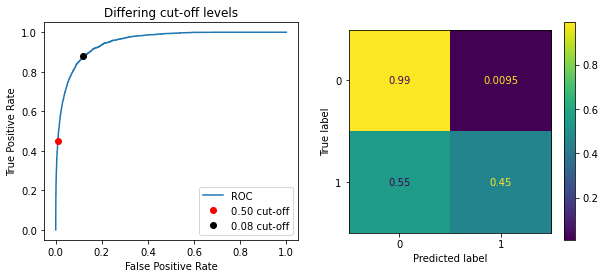

In [22]:
score_model(gbc, X_val, y_val, X_train, y_train)

Original Threshold
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     46785
           1       0.72      0.36      0.48      3096

    accuracy                           0.95     49881
   macro avg       0.84      0.68      0.73     49881
weighted avg       0.94      0.95      0.94     49881

Adjusted Threshold
              precision    recall  f1-score   support

           0       0.99      0.87      0.92     46785
           1       0.30      0.86      0.44      3096

    accuracy                           0.86     49881
   macro avg       0.64      0.86      0.68     49881
weighted avg       0.95      0.86      0.89     49881



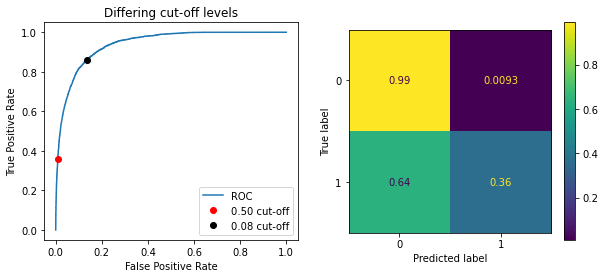

In [23]:
log_reg.set_params(**log_reg_best_params)
score_model(log_reg, X_val, y_val, X_train, y_train)

In [24]:
from sklearn.inspection import permutation_importance, plot_partial_dependence

def plot_permutation_imp(pipeline, X, y, top_n=10):
    fig, ax = plt.subplots(figsize=(12,6))
    importances = permutation_importance(pipeline, X, y, n_jobs=-1)
    importances_order = np.argsort(importances['importances_mean'])
    importances_order_trim = importances_order[-top_n:]
    labels = pipeline.named_steps['ct'].get_feature_names()
    labels = np.array([label.replace('target_cols__', '') for label in labels])

    ax.bar(labels[importances_order_trim], 
            importances['importances_mean'][importances_order_trim], 
             yerr=importances['importances_std'][importances_order_trim])
    ax.set_title('Permutation Importance')
    ax.set_ylabel('Model Score Improvement')
    ax.tick_params(axis='x', rotation=90)
    return

def plot_partial_dep(pipeline, X, y, col_index=None, axs=None):
    labels = pipeline.named_steps['ct'].get_feature_names()
    labels = np.array([label.replace('target_cols__', '') for label in labels])
    model = pipeline.named_steps['model']
    X_transf = pipeline.named_steps['ct'].transform(X)
    plot_partial_dependence(model, X_transf, col_index, feature_names=labels,
                            n_jobs=-1, percentiles=(0,1), ax=axs)
    return

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


Original Threshold
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     93576
           1       0.73      0.42      0.53      6186

    accuracy                           0.95     99762
   macro avg       0.85      0.71      0.76     99762
weighted avg       0.95      0.95      0.95     99762

Adjusted Threshold
              precision    recall  f1-score   support

           0       0.99      0.87      0.93     93576
           1       0.31      0.87      0.46      6186

    accuracy                           0.87     99762
   macro avg       0.65      0.87      0.69     99762
weighted avg       0.95      0.87      0.90     99762



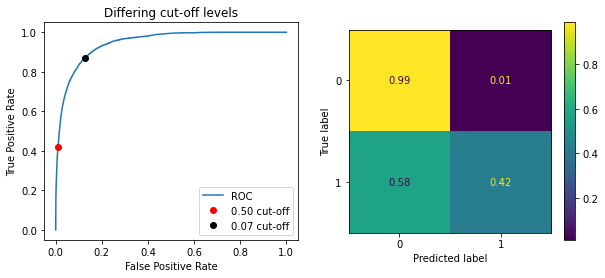

In [25]:
test = read_data('census_income_test.csv', print_summary=False, sep=', ', names=in_col_names, na_values='?')

col_names = ['migration_code-change_in_msa',
            'migration_code-change_in_reg',
            'migration_code-move_within_reg',
            'migration_prev_res_in_sunbelt',
            'instance_weight']

#dropping col_names and changing year and occupation code to str for categorical variables
drop_change_cols(test, col_names, change_col_type={str:['year', 'occupation_code']})

#mapping codes to descriptions
map_categorical_columns(test, ['industry_code', 
                               'own_business_or_self_employed', 
                               'veterans_benefits'])

X_test, y_test = prep_X_y(test[FS_cols], test.target)
score_model(rf, X_test, y_test, X, y, best_cut_off=0.07)

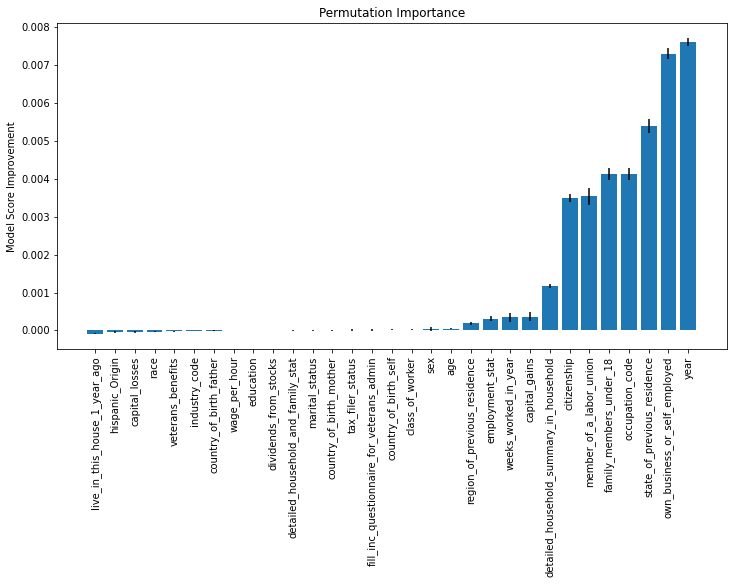

In [26]:
plot_permutation_imp(rf, X_test, y_test, top_n=31)

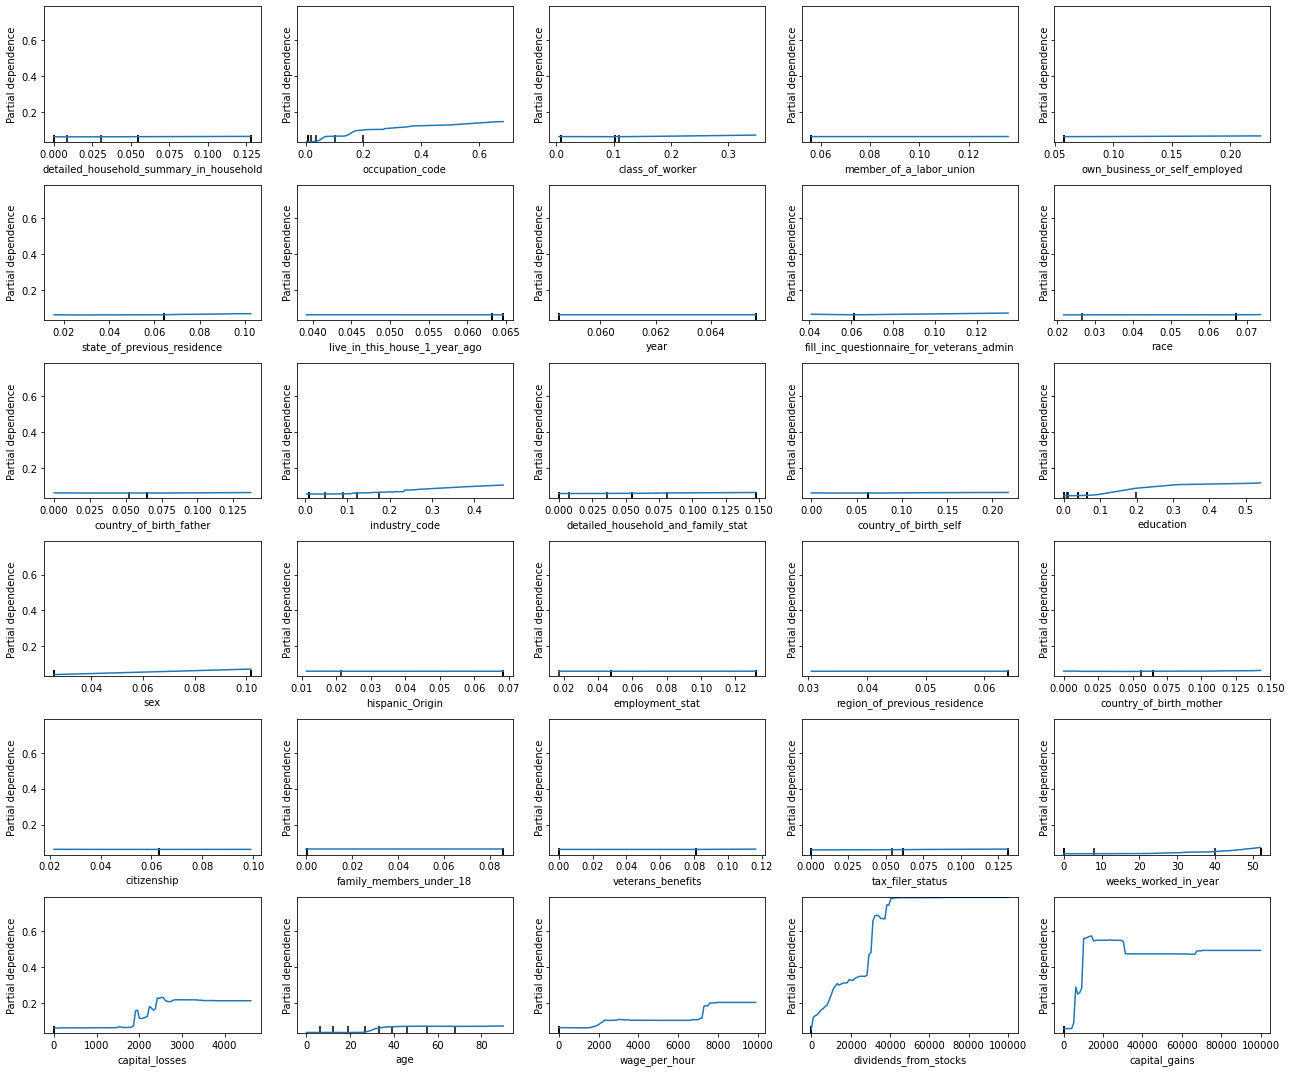

In [27]:
fig, axs = plt.subplots(6, 5, figsize=(18, 15), sharey=True)

n = np.arange(30)
n[24] = 30
plot_partial_dep(rf, X_test, y_test, col_index=n, axs=axs.ravel())
fig.tight_layout()

Original Threshold
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     93576
           1       0.74      0.45      0.56      6186

    accuracy                           0.96     99762
   macro avg       0.85      0.72      0.77     99762
weighted avg       0.95      0.96      0.95     99762

Adjusted Threshold
              precision    recall  f1-score   support

           0       0.99      0.87      0.93     93576
           1       0.32      0.89      0.47      6186

    accuracy                           0.88     99762
   macro avg       0.65      0.88      0.70     99762
weighted avg       0.95      0.88      0.90     99762



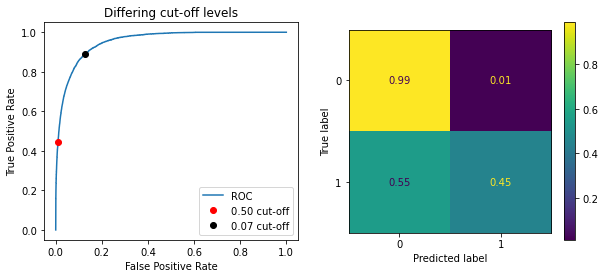

In [28]:
score_model(gbc, X_test, y_test, X, y, best_cut_off=0.07)

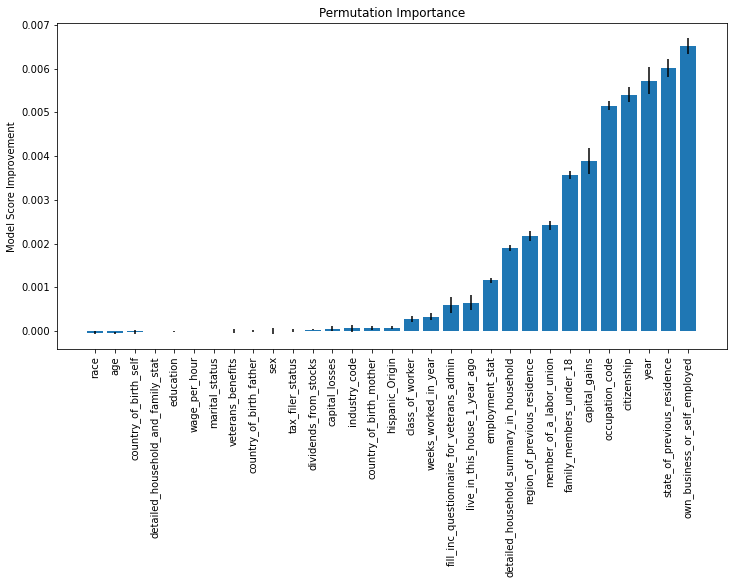

In [30]:
plot_permutation_imp(gbc, X_test, y_test, top_n=31)

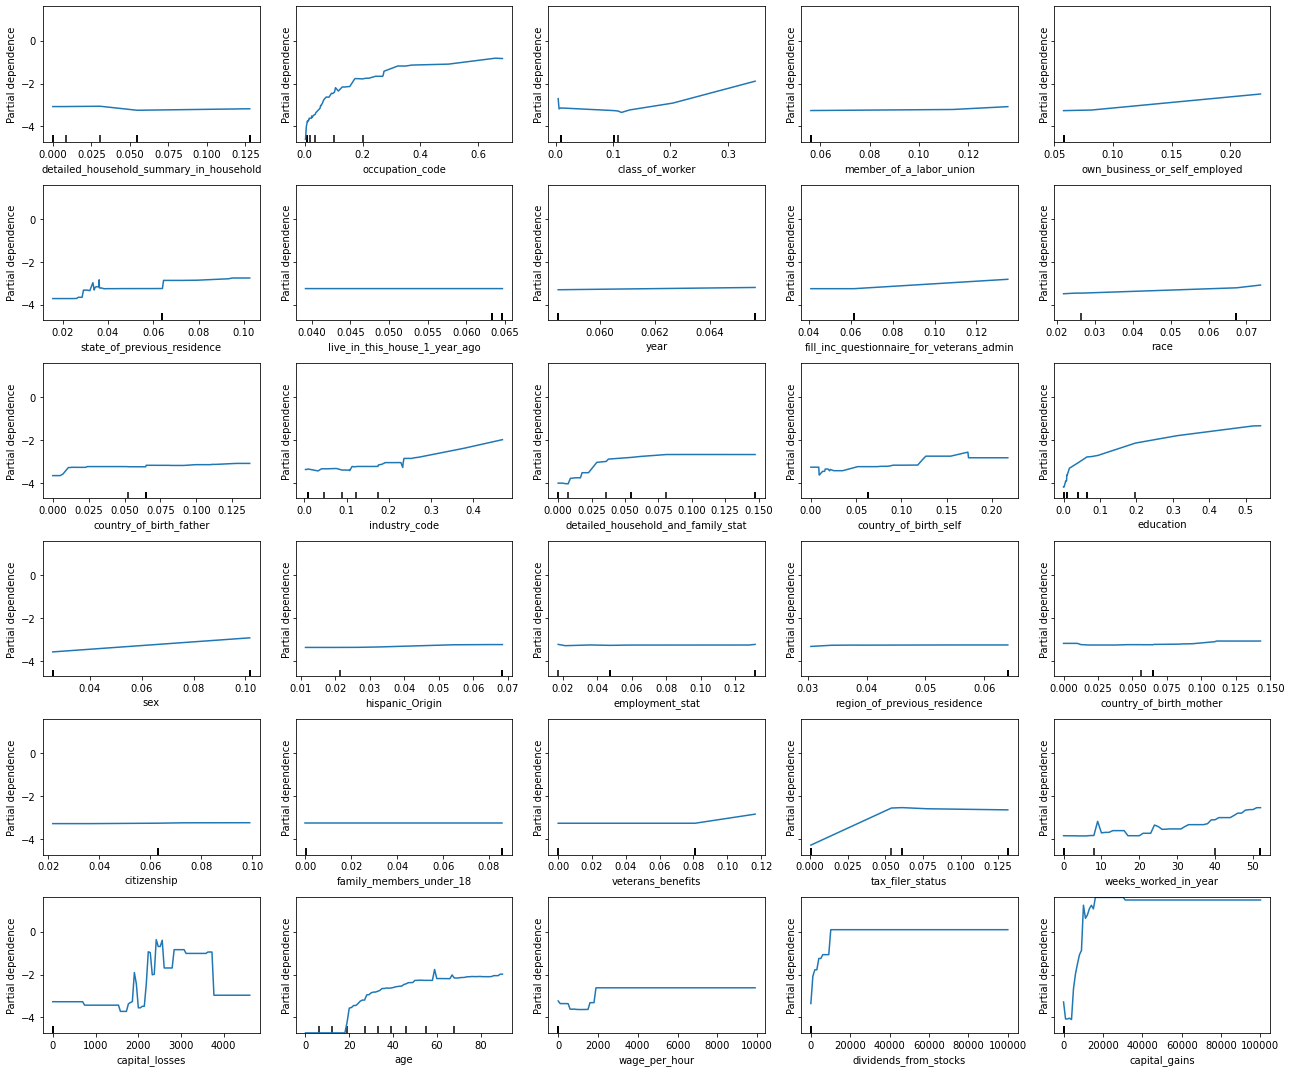

In [31]:
fig, axs = plt.subplots(6, 5, figsize=(18, 15), sharey=True)

n = np.arange(30)
n[24] = 30
plot_partial_dep(gbc, X_test, y_test, col_index=n, axs=axs.ravel())
fig.tight_layout()